In [1]:
"""룰 기반 공행성 탐색 + LightGBM 회귀 예측 파이프라인 (v3).

1. train_month.csv를 월별 value 합계 pivot으로 변환
2. 피어슨 상관계수 규칙으로 (leader, follower) 공행성 쌍 탐색
3. follower/leader lag, diff, ratio 등 피처 생성 후 LightGBM 회귀 학습
4. 2025-08을 대상으로 pair별 value 예측
5. submission_{tag}_{오늘날짜}.csv 저장
"""
from __future__ import annotations
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

---------------------------------------------------------------------------
0. 데이터 적재 및 월별 pivot 생성
---------------------------------------------------------------------------

In [2]:
def load_monthly_data(path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """train_month.csv를 읽어 item_id × ym pivot 생성."""

    df = pd.read_csv(path)
    df["ym"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

    monthly = (
        df.groupby(["item_id", "ym"], as_index=False)["value"]
        .sum()
        .rename(columns={"value": "value_sum"})
    )
    pivot = (
        monthly.pivot_table(index="ym", columns="item_id", values="value_sum", aggfunc="sum")
        .sort_index()
        .fillna(0.0)
    )
    return monthly, pivot

---------------------------------------------------------------------------
1. 공행성 쌍 탐색 (룰 기반)
---------------------------------------------------------------------------

In [3]:
def safe_corr(x: np.ndarray, y: np.ndarray) -> float:
    """분산=0 예외를 처리한 피어슨 상관계수."""

    if x.std() == 0 or y.std() == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

In [4]:
def find_comovement_pairs(
    pivot: pd.DataFrame,
    max_lag: int = 6,
    min_nonzero: int = 12,
    corr_threshold: float = 0.4,
) -> pd.DataFrame:
    """피어슨 룰 기반으로 (leader, follower) 공행성 쌍 탐색."""

    items = pivot.columns.tolist()
    pairs: List[Dict[str, float]] = []

    for leader in items:
        leader_series = pivot[leader].values.astype(float)
        if np.count_nonzero(leader_series) < min_nonzero:
            continue
        for follower in items:
            if leader == follower:
                continue
            follower_series = pivot[follower].values.astype(float)
            if np.count_nonzero(follower_series) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            for lag in range(1, max_lag + 1):
                if len(leader_series) <= lag:
                    break
                x = leader_series[:-lag]
                y = follower_series[lag:]
                corr = safe_corr(x, y)
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is None or abs(best_corr) < corr_threshold:
                continue

            pairs.append(
                {
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": int(best_lag),
                    "max_corr": float(best_corr),
                }
            )

    return pd.DataFrame(pairs)

---------------------------------------------------------------------------
2. 회귀용 학습 데이터 구성
---------------------------------------------------------------------------

In [5]:
def _build_pair_frame(
    pivot: pd.DataFrame,
    leader: str,
    follower: str,
    best_lag: int,
    max_corr: float,
) -> pd.DataFrame:
    """단일 pair에 대한 시점별 피처 계산."""

    leader_series = pivot[leader]
    follower_series = pivot[follower]

    df = pd.DataFrame({
        "date": pivot.index,
        "b_t": follower_series.values,
    })
    df["b_t_1"] = df["b_t"].shift(1)
    df["b_t_2"] = df["b_t"].shift(2)
    #df["b_t_3"] = df["b_t"].shift(3)
    #df["b_t_4"] = df["b_t"].shift(4)
    #df["b_t_5"] = df["b_t"].shift(5)
    df["b_diff1"] = df["b_t"] - df["b_t_1"]
    df["b_pct1"] = (df["b_t"] - df["b_t_1"]) / (df["b_t_1"].replace(0, np.nan) + 1e-6)
    df["b_roll3"] = follower_series.rolling(window=3, min_periods=3).mean().values
    #df["b_roll6"] = follower_series.rolling(window=6, min_periods=6).mean().values
    #df["b_roll12"] = follower_series.rolling(window=12, min_periods=12).mean().values

    # 타깃 등
    df["target_value"] = df["b_t"].shift(-1)
    df["target_log1p"] = np.log1p(df["target_value"].clip(lower=0))
    df["target_date"] = df["date"] + pd.offsets.MonthBegin(1)

    # 메타 정보
    df["leading_item_id"] = leader
    df["following_item_id"] = follower
    df["best_lag"] = best_lag
    df["max_corr"] = max_corr

    required_cols = [
        "b_t",
        "b_t_1",
        "b_t_2",
        "b_roll3",
        "b_diff1",
        "b_pct1",
        "a_t_lag",
        "a_t_lag_1",
        "a_diff_lag",
        "a_pct_lag",
        "target_value",
    ]
    
    # 필요한 경우 b_t_3~5, b_roll6/12도 추가!

    df = df.dropna(subset=[col for col in required_cols if col in df.columns])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

In [6]:
def build_training_data(pivot: pd.DataFrame, pairs: pd.DataFrame) -> pd.DataFrame:
    """모든 pair에 대한 학습용 레코드 결합."""

    frames = []
    for _, row in pairs.iterrows():
        pair_frame = _build_pair_frame(
            pivot,
            leader=row["leading_item_id"],
            follower=row["following_item_id"],
            best_lag=row["best_lag"],
            max_corr=row["max_corr"],
        )
        if not pair_frame.empty:
            frames.append(pair_frame)

    if not frames:
        raise ValueError("학습 데이터가 생성되지 않았습니다.")
    df = pd.concat(frames, ignore_index=True)
    df = df[df["target_date"].notna()]
    return df

---------------------------------------------------------------------------
3. LightGBM 회귀 모델 학습
---------------------------------------------------------------------------

In [7]:
def lgbm_gridsearch(X_train, y_train, X_valid, y_valid, param_grid):
    best_results = []
    best_rmse = float("inf")
    best_params = None
    best_model = None
    for lr in param_grid["learning_rate"]:
        for n_leaves in param_grid["num_leaves"]:
            for max_depth in param_grid["max_depth"]:
                model = LGBMRegressor(
                    objective="regression",
                    n_estimators=1000,
                    learning_rate=lr,
                    num_leaves=n_leaves,
                    max_depth=max_depth,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    verbosity=-1,
                )
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric="l2")
                y_pred = model.predict(X_valid)
                rmse = mean_squared_error(y_valid, y_pred) ** 0.5
                best_results.append({
                    "learning_rate": lr,
                    "num_leaves": n_leaves,
                    "max_depth": max_depth,
                    "rmse": rmse
                })
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {"learning_rate": lr, "num_leaves": n_leaves, "max_depth": max_depth}
                    best_model = model

    # 상위 5개만 RMSE 기준 오름차순 정렬 후 출력
    topn = 5
    best_results = sorted(best_results, key=lambda x: x["rmse"])
    print("Top parameter sets:")
    for r in best_results[:topn]:
        print(f"LR={r['learning_rate']}, Leaves={r['num_leaves']}, Depth={r['max_depth']} | RMSE={r['rmse']:.6f}")

    print(f"\nBest Params: {best_params} | Best RMSE: {best_rmse:.6f}")
    return best_model, best_params, best_rmse


In [8]:
def train_regression_model(train_df: pd.DataFrame) -> Tuple[LGBMRegressor, List[str]]:
    train_cutoff = pd.Timestamp("2024-12-01")
    valid_start = pd.Timestamp("2025-01-01")
    valid_end = pd.Timestamp("2025-05-01")

    drop_cols = {"date", "target_date", "target_value", "target_log1p", "leading_item_id", "following_item_id"}
    feature_cols = [col for col in train_df.columns if col not in drop_cols]

    train_mask = train_df["target_date"] <= train_cutoff
    valid_mask = (train_df["target_date"] >= valid_start) & (train_df["target_date"] <= valid_end)

    if train_mask.sum() == 0 or valid_mask.sum() == 0:
        raise ValueError("train/valid 기간 데이터가 부족합니다.")

    X_train = train_df.loc[train_mask, feature_cols]
    y_train = train_df.loc[train_mask, "target_log1p"]
    X_valid = train_df.loc[valid_mask, feature_cols]
    y_valid = train_df.loc[valid_mask, "target_log1p"]

    param_grid = {
        "learning_rate": [0.03, 0.05, 0.07, 0.1, 0.13, 0.15, 0.18, 0.2],  # 0.05~0.2 사이 추가!
        "num_leaves": [31, 63, 95, 127, 160],  # 95, 160 등 추가 (63~127~160 구간)
        "max_depth": [7, 12, 15, 20, -1]
    }

    best_model, best_params, best_rmse = lgbm_gridsearch(X_train, y_train, X_valid, y_valid, param_grid)
    return best_model, feature_cols


In [9]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_cols, topn=20):
    imp = model.feature_importances_
    # 상위 N개만 보기
    sorted_idx = np.argsort(imp)[::-1][:topn]
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_cols)[sorted_idx], imp[sorted_idx])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    # 중요도 내림차순 순서의 feature 이름 리스트 반환(자동화 실험용)
    return list(np.array(feature_cols)[sorted_idx])




---------------------------------------------------------------------------
4. 예측 월 피처 생성
---------------------------------------------------------------------------

In [10]:
def build_inference_features(
    pivot: pd.DataFrame,
    pairs: pd.DataFrame,
    forecast_month: str,
) -> pd.DataFrame:
    """forecast_month(예: 2025-08)에 대한 pair별 입력 피처 생성."""

    target_ts = pd.Timestamp(forecast_month + "-01")
    base_ts = target_ts - pd.offsets.MonthBegin(1)
    if base_ts not in pivot.index:
        raise ValueError(f"{base_ts.date()} 기준 데이터가 없습니다.")

    rows = []
    for _, row in pairs.iterrows():
        pair_frame = _build_pair_frame(
            pivot,
            leader=row["leading_item_id"],
            follower=row["following_item_id"],
            best_lag=row["best_lag"],
            max_corr=row["max_corr"],
        )
        target_row = pair_frame[pair_frame["target_date"] == target_ts]
        if not target_row.empty:
            rows.append(target_row.iloc[0].copy())

    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows)

---------------------------------------------------------------------------
5. 제출 파일 생성
---------------------------------------------------------------------------

In [11]:
def create_submission(
    pairs: pd.DataFrame,
    pred_df: pd.DataFrame,
    pivot: pd.DataFrame,
    model: LGBMRegressor,
    feature_cols: List[str],
) -> pd.DataFrame:
    """pair 목록에 예측 value를 결합하여 submission 생성."""

    submission = pairs[["leading_item_id", "following_item_id"]].drop_duplicates().reset_index(drop=True)
    latest_map = pivot.iloc[-1].to_dict()

    if pred_df.empty:
        submission["value"] = submission["following_item_id"].map(latest_map).fillna(0.0)
    else:
        X_test = pred_df[feature_cols].fillna(0.0)
        y_pred = model.predict(X_test)
        y_pred = np.maximum(0.0, np.expm1(y_pred))
        pred_values = pred_df[["leading_item_id", "following_item_id"]].copy()
        pred_values["value"] = y_pred

        submission = submission.merge(
            pred_values,
            on=["leading_item_id", "following_item_id"],
            how="left",
        )
        submission["value"] = submission["value"].fillna(
            submission["following_item_id"].map(latest_map)
        )

    submission["value"] = submission["value"].fillna(0.0)
    submission["value"] = submission["value"].clip(lower=0).round().astype(int)
    submission.drop_duplicates(["leading_item_id", "following_item_id"], inplace=True)
    submission.reset_index(drop=True, inplace=True)
    return submission

---------------------------------------------------------------------------
6. 메인 실행부 (sweep으로 교체)
---------------------------------------------------------------------------

In [12]:
def sweep_thresholds_and_select_topN(
    pivot, 
    thresholds = [0.25, 0.28, 0.32, 0.35, 0.40],
    topN=3,
    min_nonzero=12
):
    results = []
    for th in thresholds:
        try:
            pairs = find_comovement_pairs(
                pivot, max_lag=6, min_nonzero=min_nonzero, corr_threshold=th
            )
            print(f"Threshold={th}: pairs={len(pairs)}")
            if pairs.empty:
                print(f"Threshold={th}: No pairs found, skipped")
                continue
            train_df = build_training_data(pivot, pairs)
            print(f"Threshold={th}: train_df rows={len(train_df)}")
            model, feature_cols = train_regression_model(train_df)
            
            # Validation set 추출
            valid_start = pd.Timestamp("2025-01-01")
            valid_end = pd.Timestamp("2025-05-01")
            valid_mask = (
                (train_df["target_date"] >= valid_start) & (train_df["target_date"] <= valid_end)
            )
            X_valid = train_df.loc[valid_mask, feature_cols]
            y_valid = train_df.loc[valid_mask, "target_log1p"]

            # Validation Score (예: RMSE)
            from sklearn.metrics import mean_squared_error
            y_pred = model.predict(X_valid)
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

            results.append({
                'threshold': th,
                'rmse': rmse,
                'pair_count': len(pairs),
                # 필요시 model, feature_cols 등 추가 저장
            })

            print(f"Threshold={th:.3f} | pairs={len(pairs)} | Validation RMSE={rmse:.6f}")

        except Exception as e:
            print(f"Threshold={th:.3f}: {e}")

    # Top-N 성적 좋은 후보만 정렬 출력
    results = sorted(results, key=lambda x: x['rmse'])
    print("\n--- Top N Validation Candidates ---")
    for i, r in enumerate(results[:topN]):
        print(f"Rank {i+1}: threshold={r['threshold']:.3f} | pairs={r['pair_count']} | RMSE={r['rmse']:.6f}")
    
    return results[:topN]


pivot columns: Index(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ',
       'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG',
       'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB',
       'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN',
       'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH',
       'GMBFCMIU', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
       'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KFQSHBNH',
       'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML',
       'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU',
       'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU',
       'QKXNTIIB', 'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
       'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU', 'SAHWCZNH',
       'SDWAYPIK', 'SNHYOVBM', 'STZDB

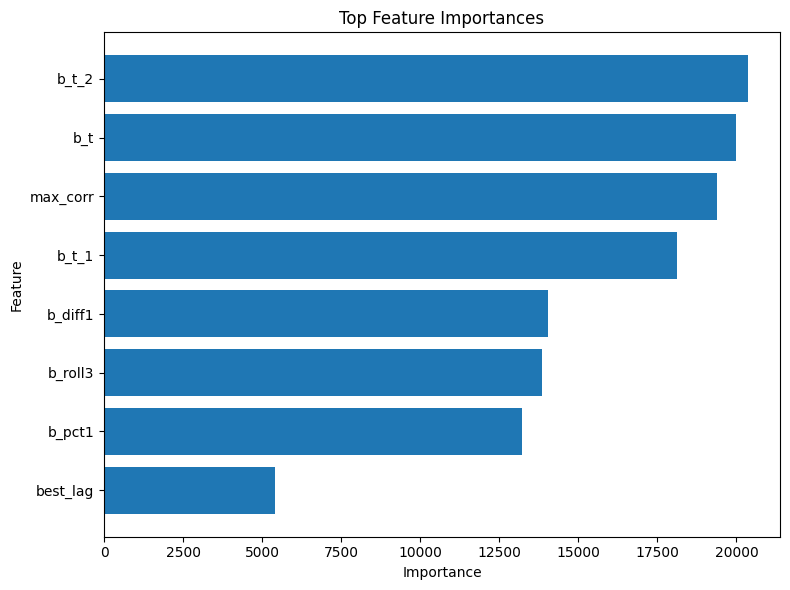

submission_rulelgbm_v3_th38_20251122.csv 저장 완료 (총 1742개 pair)


In [13]:
def main():
    data_path = "train_month.csv"
    forecast_month = "2025-08"
    thresholds = [0.38, 0.40, 0.43, 0.45, 0.48, 0.52]  # 0.4~0.5 구간으로 올려서 실험!
    topN = 3
    min_nonzero = 10        

    # pivot 먼저 정의!
    _, pivot = load_monthly_data(data_path)
    print("pivot columns:", pivot.columns)
    print("pivot shape:", pivot.shape)
    print("nonzero counts:", [np.count_nonzero(pivot[col]) for col in pivot.columns])

    # 그 다음 sweep 함수 실행!
    top_candidates = sweep_thresholds_and_select_topN(pivot, thresholds, topN, min_nonzero=min_nonzero)
    if not top_candidates:
        raise ValueError("Sweep 후보가 없습니다. threshold 범위, 데이터 조건, 쌍 생성 결과를 점검하세요.")
    best = top_candidates[0]

    pairs = find_comovement_pairs(
        pivot, max_lag=6, min_nonzero=min_nonzero, corr_threshold=best["threshold"]
    )
    train_df = build_training_data(pivot, pairs)
    model, feature_cols = train_regression_model(train_df)
    plot_feature_importance(model, feature_cols, topn=20)

    pred_df = build_inference_features(pivot, pairs, forecast_month)
    submission = create_submission(pairs, pred_df, pivot, model, feature_cols)
    today = pd.Timestamp.today().strftime("%Y%m%d")
    output_path = f"submission_rulelgbm_v3_th{int(best['threshold']*100)}_{today}.csv"
    submission.to_csv(output_path, index=False)
    print(f"{output_path} 저장 완료 (총 {len(submission)}개 pair)")

if __name__ == "__main__":
    main()
